## Digit recognizer

MNIST(modifed national institute of standard and technology) is the "Hello world" dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classficiation algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for resource for researchers and leaaners alike.

In this competition, your goal is to correctly identify digits from a dataset from a dataset of tens of thousands of handwritten images. We have curated a set of tutorial-style kernels which cover everything from regression to neural networks. We encourage you to experiment with different algorithms  to learn first-hand works well and how techique compare.


In [48]:
import numpy as np # 线性代数
import pandas as pd # 数据预处理
import matplotlib.pyplot as plt # 绘图
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from torch.utils.data import Dataset
device = torch.device('mps')

## 0x01 dataset

In [79]:
# csv -> pd.DataFrame
trainDF = pd.read_csv('../DigitRecongnier/data/train.csv')

# pd.DataFrame -> numpy.array
labels = trainDF['label'].values
train = trainDF.drop(['label'],axis=1)
features = train.values

# 划分数据集和测试集
features_train,features_test,targets_train,targets_test = train_test_split(features,labels,test_size=0.2,random_state=42)
# def split_data(features,labels,per):
#     '''按照per划分数据集'''
#     split_len=int(per*len(labels))
#     trainFeatures = features[:split_len]
#     trainLabels = labels[:split_len]
#     valFeatures = features[split_len:]
#     valLabels = labels[split_len:]
#     return trainFeatures,trainLabels,valFeatures,valLabels
# trainFeatures,trainLabels,valFeatures,valLabels = split_data(features,labels,0.8)

# numpy.array -> tensor
featuresTrain = torch.from_numpy(features_train)/255
targetsTrain = torch.from_numpy(targets_train)
featuresTest = torch.from_numpy(features_test)/255
targetsTest = torch.from_numpy(targets_test)

# trainF = torch.tensor(trainFeatures)
# trainFS = trainF.reshape((-1,28,28))
# # 证明前后是一样的
# trainF[0] == trainFS[0].reshape(1,-1)

# # tensor -> dataset(using tensordataset) 
# # 缺点是不能使用transform
# train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
# test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

# tensor -> data (using super the dataset)
class TensorDatasetSelf(Dataset):
    ''' tensor dataset 继承 dataset 只需要重载len和getitem就可以'''
    def __init__(self,features,target,transform=None) -> None:
        super().__init__()
        self.datatensor = features
        self.labeltensor = target
        self.transform = transform 
    
    def __len__(self):
        return self.datatensor.size(0)
    
    def __getitem__(self, index):
        cur = self.datatensor[index]
        X = cur.reshape((1,28,28))
        return X,self.labeltensor[index]

# 定义一个变换，将数据缩放到 0 到 1 的范围内
# 坑：Resize返回一个image
# transform = transforms.Compose([transforms.Resize((28,28)),transforms.ToTensor()])

train  = TensorDatasetSelf(featuresTrain,targetsTrain)
test = TensorDatasetSelf(featuresTest,targetsTest)

Hint01 : torch构建dataset的几种方式
1. 自定义Dataset类，可以通过继承torch.utils.data.Dataset来实现，需要重写__len__(),__getitem__()类
2. 使用tensorDataset类，是一个包装器类，实现从tensor到dataset的直接的转变

#### Hint02 Dataset中添加数据预处理
我们输入features、labels进入dataset类之后，在输出的时候我们可能希望对其进行一些预处理

比如图像增强常用的预处理、增强、旋转等等

from torchvision import transforms

transforms.compose()类似pipeline，来实现一系列的transform操作，常见的transform操作有：

1. transforms.ToTensor()
2. 自定义transforms


## Dataloader

In [80]:
# 构建数据集的超参数设置
batchsize = 128
epoches = 20

# dataset -> dataloader
train_iter = DataLoader(train,batch_size=batchsize,shuffle=False)
test_iter = DataLoader(test,batch_size=batchsize,shuffle=False)

torch.Size([128, 1, 28, 28])


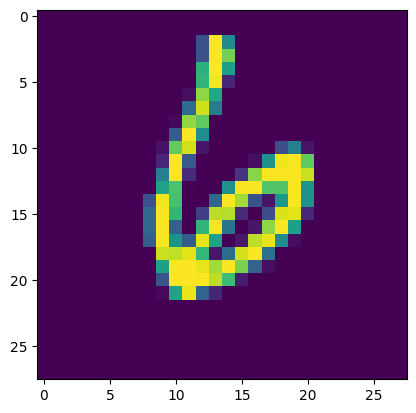

In [83]:
# tensor 也可以 plt！
for X,y in train_iter:
    print(X.shape)
    cur = X[0][0]
    plt.imshow(cur)
    plt.show()
    break

## Model

In [85]:
# 使用经典的CNN模型
class LeNet(nn.Module):
    def __init__(self):
        '''input :28*28,output:10'''
        super().__init__()
    
       # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
     
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        # Fully connected 1
        self.fc1 = nn.Linear(32 * 16, 10) 
    
    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        
        # Max pool 1
        out = self.maxpool1(out)
        
        # Convolution 2 
        out = self.cnn2(out)
        out = self.relu2(out)
        
        # Max pool 2 
        out = self.maxpool2(out)
        
        # flatten
        # out = out.view(1, -1)
        out = out.view(out.size(0), -1)

        # Linear function (readout)
        out = self.fc1(out)
        
        return out

model  = LeNet()

# testTensor = torch.randint(0,255,(1,28,28),dtype=torch.float)
# model (testTensor)

## 损失函数

In [87]:
##
loss = nn.CrossEntropyLoss()

## 优化器

In [88]:
learning_rate = 0.03
opt = torch.optim.SGD(model.parameters(),lr=learning_rate)

## 训练


In [93]:
# trian with(data_iter,model,loss,optimizer)

# 将模型添加到device中
model =model.to(device)

# 训练多个epoch
for epoch in range(epoches):
    # 训练多个iter
    for X,y in train_iter:
        # 
        X,y = X.to(device),y.to(device)
        model.train()
        opt.zero_grad()
        l = loss(model(X),y)
        l.mean().backward()
        opt.step()

# to choice a better model，this should be train ata

tensor(0.0187, device='mps:0', grad_fn=<MeanBackward0>)
tensor(0.1247, device='mps:0', grad_fn=<MeanBackward0>)
tensor(0.0749, device='mps:0', grad_fn=<MeanBackward0>)
tensor(0.0430, device='mps:0', grad_fn=<MeanBackward0>)
tensor(0.0367, device='mps:0', grad_fn=<MeanBackward0>)
tensor(0.0344, device='mps:0', grad_fn=<MeanBackward0>)
tensor(0.0838, device='mps:0', grad_fn=<MeanBackward0>)
tensor(0.0449, device='mps:0', grad_fn=<MeanBackward0>)
tensor(0.0600, device='mps:0', grad_fn=<MeanBackward0>)
tensor(0.0525, device='mps:0', grad_fn=<MeanBackward0>)
tensor(0.0318, device='mps:0', grad_fn=<MeanBackward0>)
tensor(0.0450, device='mps:0', grad_fn=<MeanBackward0>)
tensor(0.0937, device='mps:0', grad_fn=<MeanBackward0>)
tensor(0.0294, device='mps:0', grad_fn=<MeanBackward0>)
tensor(0.0358, device='mps:0', grad_fn=<MeanBackward0>)
tensor(0.1066, device='mps:0', grad_fn=<MeanBackward0>)
tensor(0.0462, device='mps:0', grad_fn=<MeanBackward0>)
tensor(0.0782, device='mps:0', grad_fn=<MeanBack

## Test

In [108]:
valDF = pd.read_csv('../DigitRecongnier/data/test.csv')
valtensor = torch.tensor(valDF.values,dtype=torch.float,device=device)

In [109]:
valtensor = valtensor.view((-1,1,28,28))
result = model(valtensor)

In [126]:
res = torch.argmax(result,dim=1)
index =pd.Series(np.arange(1,28001))
res =res.to('cpu')
label = pd.Series(res)
df = pd.DataFrame({'ImageId':index,'Label':label})
df.to_csv('../DigitRecongnier/data/sample_submission.csv',index=False)